In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc 
import math as Math
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, TimeDistributed, LSTM, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import os

#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
BASIN = 'WP2020-21' # Change to BASIN you want to work for

path1 = os.getcwd()+'/'

#Limiting GPU RAM. Comment these lines if you are not working on a shared GPU.
config = tensorflow.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
config.gpu_options.allow_growth=True
sess = tensorflow.compat.v1.Session(config=config)

In [2]:
filePath = path1 + 'WP2020-21pressureSSTData72hour.csv'
data = pd.read_csv(filePath, index_col=0)

In [3]:
#Generating the features distance and direction for 6 hourly data.

total_hurricane_count = len(pd.unique(data['SID']))
total_data_count = data.shape[0]

keys = list(enumerate(pd.unique(data['SID'])))

y = np.zeros(total_hurricane_count)
data['distance'] = np.zeros(total_data_count)
data['direction'] = np.zeros(total_data_count)

# For all hurricanes
for x in range(0, total_hurricane_count):
    t = pd.DataFrame(data[data['SID'] == keys[x][1]], columns = data.keys()).reset_index(drop = False)
    dst = 0
    prev = (0,0)
    # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
    for p in zip(t['LAT'], t['LON']):
        if prev == (0,0):
            prev = p
            continue 
        # Stores the distance into the DataFrame
        data.at[t[(t['LAT'] == p[0]) & (t['LON'] == p[1])]['index'].values[0], 'distance'] =  vc(prev,p).km
        
        dLon = p[1] - prev[1];  
        temp = float(p[0]) # p[0] is a str?
        y_x = Math.sin(dLon) * Math.cos(temp);
        
        x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
        brng = Math.degrees(Math.atan2(y_x, x_x)) 
        if (brng < 0):
            brng+= 360;
        
        # Stores the angle of travel into the DataFrame
        data.at[t[(t['LAT'] == p[0]) & (t['LON'] == p[1])]['index'].values[0], 'direction']= brng
        dst += vc(prev,p).km
        prev = p
    y[x] = dst


In [4]:
#Generating two random TC with 72 hour of data, one each with landfall and withot landfall
sids = np.unique(data['SID'])
length = len(sids)
check = True
while check:
    rint = random.randint(0, length-1)
    sidl = sids[rint]
    cdata = data[data['SID']==sidl]
    if cdata.values[0][-1] == 1 and cdata.shape[0] == 13:
        check = False

lCyclone = sidl
check = True
while check:
    rint = random.randint(0, length-1)
    sidnl = sids[rint]
    cdata = data[data['SID']==sidnl]
    if cdata.values[0][-1] == 0  and cdata.shape[0] == 13:
        check = False

nlCyclone = sidnl

#Fetching data for these two cyclones and removing it from main dataset.
ldata = data[data['SID'] ==sidl]
nldata = data[data['SID']==sidnl]
data = data[data['SID'] !=sidl]
data = data[data['SID'] !=sidnl]

In [5]:
total_hurricane_count = len(pd.unique(data['SID']))
print("total hurricane count  ", total_hurricane_count)
gridSize = 65
total = gridSize*gridSize
scalers = {}
cols = ['DIST2LAND','LAT','LON','distance','direction']

for i in range(total):
  cols.append('u225_'+str(i))
for i in range(total):
  cols.append('u500_'+str(i))
for i in range(total):
  cols.append('u700_'+str(i))
for i in range(total):
  cols.append('v225_'+str(i))
for i in range(total):
  cols.append('v500_'+str(i))
for i in range(total):
  cols.append('v700_'+str(i))
for i in range(total):
  cols.append('z225_'+str(i))
for i in range(total):
  cols.append('z500_'+str(i))
for i in range(total):
  cols.append('z700_'+str(i))

#Scaling fetures with Min Max Scaler
for col in cols:
    scaler = MinMaxScaler((-1,1))
    scaler.fit(data[[col]])
    data[[col]] = scaler.transform(data[[col]])
    ldata[[col]] = scaler.transform(ldata[[col]])
    nldata[[col]] = scaler.transform(nldata[[col]])

cols.append('isLandfall')

data_pad = []
data_padl = []
data_padnl = []
for key in np.unique(data['SID']):
    data_pad += [data[ data.loc[:, 'SID'] == key].loc[:, cols].values]
    
data_padl+=[ldata.loc[:, cols].values]
data_padnl+=[nldata.loc[:, cols].values]

total hurricane count   16


In [6]:
# Extracting features indexes and adjusting them as per used features, to index in data_pad.

offset = 2

u225fIndex = data.columns.get_loc('u225_0')-offset
u225lIndex = data.columns.get_loc('u225_4224')-offset 
v225fIndex = data.columns.get_loc('v225_0')-offset
v225lIndex = data.columns.get_loc('v225_4224')-offset 
z225fIndex = data.columns.get_loc('z225_0')-offset
z225lIndex = data.columns.get_loc('z225_4224')-offset

u500fIndex = data.columns.get_loc('u500_0')-offset
u500lIndex = data.columns.get_loc('u500_4224')-offset
v500fIndex = data.columns.get_loc('v500_0')-offset
v500lIndex = data.columns.get_loc('v500_4224')-offset
z500fIndex = data.columns.get_loc('z500_0')-offset
z500lIndex = data.columns.get_loc('z500_4224')-offset

u700fIndex = data.columns.get_loc('u700_0')-offset
u700lIndex = data.columns.get_loc('u700_4224')-offset
v700fIndex = data.columns.get_loc('v700_0')-offset
v700lIndex = data.columns.get_loc('v700_4224')-offset 
z700fIndex = data.columns.get_loc('z700_0')-offset 
z700lIndex = data.columns.get_loc('z700_4224')-offset 

isLandfallIndex = data.columns.get_loc('isLandfall')-offset

gridSize = 65

#Training dataset prepearation for Reanalysis branch. 
def load_dataCNN(data_pad, trainPoints):
    X = []
    y = []
    count  = 0
    for cdata in data_pad:
      count = count + 1
      yy = cdata[0][isLandfallIndex]
      length = len(cdata)
      diff = length - trainPoints +1
      for i in range(diff):
          data2 = []
          cc1 = cdata[i : i + trainPoints]
          for j in range(trainPoints):
              data1 = []
              value = cc1[j]
            
              u225 = np.reshape(value[u225fIndex: u225lIndex+1], (gridSize,gridSize))
              u500 = np.reshape(value[u500fIndex: u500lIndex+1], (gridSize,gridSize))
              u700 = np.reshape(value[u700fIndex: u700lIndex+1], (gridSize,gridSize))

              v225 = np.reshape(value[v225fIndex: v225lIndex+1], (gridSize,gridSize))
              v500 = np.reshape(value[v500fIndex: v500lIndex+1], (gridSize,gridSize))
              v700 = np.reshape(value[v700fIndex: v700lIndex+1], (gridSize,gridSize))

              z225 = np.reshape(value[z225fIndex: z225lIndex+1], (gridSize,gridSize))
              z500 = np.reshape(value[z500fIndex: z500lIndex+1], (gridSize,gridSize))
              z700 = np.reshape(value[z700fIndex: z700lIndex+1], (gridSize,gridSize))

              data1.append(u225)
              data1.append(u500)
              data1.append(u700)
              data1.append(v225)
              data1.append(v500)
              data1.append(v700)
              data1.append(z225)
              data1.append(z500)
              data1.append(z700)
              data2.append(data1)
          X.append(data2)
          y.append(yy)

    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], X.shape[3],X.shape[4])) 
    return [x_train, y]

#Training dataset prepearation for Track branch. 
def load_dataLSTM(data_pad, trainPoints):
    X = []
    y = []
    colIndexes = []
    for cdata in data_pad:
        yy = cdata[0][isLandfallIndex] 
        length = len(cdata)
        diff = length - trainPoints +1
        for i in range(diff):
            cc = cdata[i:i+trainPoints,0:5]
            X.append(cc)
            y.append(yy)
    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2])) 
    return [x_train, y]


#Model
def build_model(cnnShape, lstmShape):
    cn0 = Input(shape=cnnShape[1:])
    cn1 = TimeDistributed(Conv2D(filters=32, kernel_size=(4, 4), activation = 'relu',data_format = 'channels_first'))(cn0)
    bn0 = TimeDistributed(BatchNormalization())(cn1)
    cn2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))(bn0)
    cn3 = TimeDistributed(Conv2D(filters=64, kernel_size=(4, 4), activation = 'relu', data_format = 'channels_first'))(cn2)
    bn1 = TimeDistributed(BatchNormalization())(cn3)
    cn4 = TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))(bn1)
    cn5 = TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu', data_format = 'channels_first'))(cn4)
    bn2 = TimeDistributed(BatchNormalization())(cn5)
    cn6 = TimeDistributed(MaxPooling2D(pool_size=(3, 3),data_format = 'channels_first'))(bn2)
    cn7 = TimeDistributed(Flatten())(cn6)
    cn8 = LSTM(32, activation='relu', return_sequences=True)(cn7)
    cnl = LSTM(16, activation='relu', return_sequences=False)(cn8)

    ls0 = Input(shape=lstmShape[1:])
    ls1 = LSTM(32, activation='relu', return_sequences=True)(ls0)
    ls2 = LSTM(16, activation='relu', return_sequences=True)(ls1)
    lsl = LSTM(8, activation='relu', return_sequences=False)(ls2)

    merge = Concatenate()([cnl, lsl])

    hid1 = Dense(8, activation='relu')(merge)
    bn5 = BatchNormalization()(hid1)
    output = Dense(1, activation='sigmoid')(bn5)

    merged_model = Model([cn0, ls0], output)
    merged_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return merged_model


In [17]:
from sklearn.metrics import confusion_matrix

noOfTrain = 5 # T = 5 (24 hours)
print("===========================================================")
cnnData, yy = load_dataCNN(data_pad, noOfTrain)
lstmData, yy1 = load_dataLSTM(data_pad, noOfTrain)
yy = yy.astype(int)
yy1 = yy1.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fars = []
fnrs = []
fprs = []
tprs = []
aucs = []
for train_index, test_index in kf.split(lstmData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xl_train = lstmData[train_index]
    yl_train = yy1[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    Xl_test = lstmData[test_index]
    yl_test = yy1[test_index]
    model = build_model(cnnData.shape, lstmData.shape)
    model.fit([Xc_train, Xl_train], yl_train, batch_size=128, validation_data=([Xc_test, Xl_test], yl_test) ,epochs=40,verbose=1, shuffle = True)
    predictions = model.evaluate([Xc_test, Xl_test], yl_test)
    accuracy.append(predictions[1])
    ypred = model.predict([Xc_test, Xl_test])
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yl_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    cfm = confusion_matrix(yl_test, ypred)
    print(cfm)
    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    far = FP/(TP+FP)
    fpr = FP/(FP+TN)
    fnr = FN/(FN+TP)
    tpr = TP/(TP+FN)
    fars.append(far)
    fprs.append(fpr)
    fnrs.append(fnr)
    tprs.append(tpr)
    print("accuracy  ", accuracy)
    print("fars  ", fars)
    print("fprs  ", fprs)
    print("fnrs  ", fnrs)
    print("tprs  ", tprs)

print("5 Fold accuracy of fusion model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold fars of fusion model ", np.array(fars).mean(), ' std  ', np.array(fars).std())
print("5 Fold fprs of fusion model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())
print("5 Fold fnrs of fusion model ", np.array(fnrs).mean(), ' std  ', np.array(fnrs).std())
print("5 Fold tprs of fusion model ", np.array(tprs).mean(), ' std  ', np.array(tprs).std())    
print("5 Fold AUC of fusion model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())      

Train on 88 samples, validate on 22 samples
Epoch 1/40
88/88 [==============================] - 14s 156ms/sample - loss: 1.2075 - acc: 0.3636 - val_loss: 0.6791 - val_acc: 0.6818
Epoch 2/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.6386 - acc: 0.6364 - val_loss: 0.6745 - val_acc: 0.6818
Epoch 3/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5551 - acc: 0.6705 - val_loss: 0.6687 - val_acc: 0.6818
Epoch 4/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5131 - acc: 0.7273 - val_loss: 0.6662 - val_acc: 0.9091
Epoch 5/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4492 - acc: 0.7841 - val_loss: 0.6654 - val_acc: 0.9091
Epoch 6/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4179 - acc: 0.8068 - val_loss: 0.6700 - val_acc: 0.8636
Epoch 7/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.3787 - acc: 0.8409 - val_loss: 0.6715 - val_acc: 0.8182
Epoch 8/40
88/88 [===========

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


Train on 88 samples, validate on 22 samples
Epoch 1/40
88/88 [==============================] - 15s 170ms/sample - loss: 1.1194 - acc: 0.4318 - val_loss: 0.6875 - val_acc: 0.6818
Epoch 2/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.9498 - acc: 0.6023 - val_loss: 0.6952 - val_acc: 0.5000
Epoch 3/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5726 - acc: 0.7727 - val_loss: 0.6948 - val_acc: 0.5455
Epoch 4/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5272 - acc: 0.8068 - val_loss: 0.6916 - val_acc: 0.7273
Epoch 5/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4451 - acc: 0.8295 - val_loss: 0.6867 - val_acc: 0.8182
Epoch 6/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4039 - acc: 0.8409 - val_loss: 0.6843 - val_acc: 0.7273
Epoch 7/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4078 - acc: 0.8068 - val_loss: 0.6808 - val_acc: 0.6818
Epoch 8/40
88/88 [===========

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


Train on 88 samples, validate on 22 samples
Epoch 1/40
88/88 [==============================] - 9s 107ms/sample - loss: 0.8097 - acc: 0.3523 - val_loss: 0.6924 - val_acc: 0.6818
Epoch 2/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5880 - acc: 0.7727 - val_loss: 0.6917 - val_acc: 0.6818
Epoch 3/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.5119 - acc: 0.8068 - val_loss: 0.6917 - val_acc: 0.6364
Epoch 4/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4731 - acc: 0.8409 - val_loss: 0.6910 - val_acc: 0.6364
Epoch 5/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.4174 - acc: 0.9091 - val_loss: 0.6905 - val_acc: 0.7273
Epoch 6/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.3991 - acc: 0.9545 - val_loss: 0.6898 - val_acc: 0.7273
Epoch 7/40
88/88 [==============================] - 0s 2ms/sample - loss: 0.3657 - acc: 1.0000 - val_loss: 0.6897 - val_acc: 0.5909
Epoch 8/40
88/88 [============

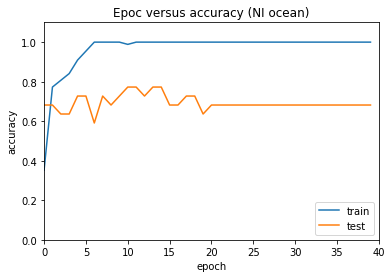

In [11]:
#Generating epoc s train versus test accuracy
noOfTrain = 5 # T = 5 (24 hours)
cnnData, yy = load_dataCNN(data_pad, noOfTrain)
lstmData, yy1 = load_dataLSTM(data_pad, noOfTrain)
model = build_model(cnnData.shape, lstmData.shape)
yy = yy.astype(int)
yy1 = yy1.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(lstmData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]
Xl_train = lstmData[train_index]
yl_train = yy1[train_index]
Xc_test = cnnData[test_index]
yc_test = yy[test_index]
Xl_test = lstmData[test_index]
yl_test = yy1[test_index]

history = model.fit([Xc_train, Xl_train], yl_train, batch_size=128, validation_data=([Xc_test, Xl_test], yl_test) ,epochs=40,verbose=1, shuffle = True)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,40,0,1.1]) 
plt.title('Epoc versus accuracy (NI ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

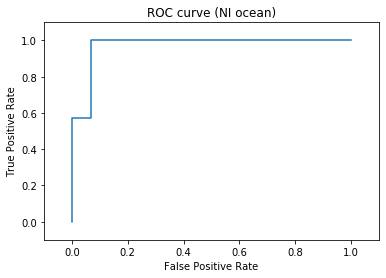

In [12]:
#Generating ROC curve for T = 5
ypred = model.predict([Xc_test, Xl_test])
ypred = ypred.reshape(len(ypred))
fpr , tpr , thresholds = roc_curve(yl_test , ypred)
plt.plot(fpr,tpr) 
plt.axis([-0.1,1.1,-0.1,1.1]) 
plt.title("ROC curve (NI ocean)")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix

noOfTrain = 3 # T = 3 (12 hours)
print("========================================================= noOfTrain", noOfTrain)
cnnData, yy = load_dataCNN(data_pad, noOfTrain)
lstmData, yy1 = load_dataLSTM(data_pad, noOfTrain)
yy = yy.astype(int)
yy1 = yy1.astype(int)
kf = KFold(n_splits=5, shuffle=True,  random_state=0)
accuracy = []
fars = []
fnrs = []
fprs = []
tprs = []
aucs = []
for train_index, test_index in kf.split(lstmData):
    Xc_train = cnnData[train_index]
    yc_train = yy[train_index]
    Xl_train = lstmData[train_index]
    yl_train = yy1[train_index]
    Xc_test = cnnData[test_index]
    yc_test = yy[test_index]
    Xl_test = lstmData[test_index]
    yl_test = yy1[test_index]
    model = build_model(cnnData.shape, lstmData.shape)
    model.fit([Xc_train, Xl_train], yl_train, batch_size=128, validation_data=([Xc_test, Xl_test], yl_test) ,epochs=40,verbose=1, shuffle = True)
    predictions = model.evaluate([Xc_test, Xl_test], yl_test)
    accuracy.append(predictions[1])
    ypred = model.predict([Xc_test, Xl_test])
    ypred = ypred.reshape(len(ypred))
    auc_score=roc_auc_score(yl_test, ypred)
    aucs.append(auc_score)
    print('aucs ',aucs)
    ypred = np.where(ypred >= 0.5, 1,0)
    cfm = confusion_matrix(yl_test, ypred)
    print(cfm)
    TN = cfm[0,0]
    FP = cfm[0,1]
    FN = cfm[1,0]
    TP = cfm[1, 1]
    far = FP/(TP+FP)
    fpr = FP/(FP+TN)
    fnr = FN/(FN+TP)
    tpr = TP/(TP+FN)
    fars.append(far)
    fprs.append(fpr)
    fnrs.append(fnr)
    tprs.append(tpr)
    print("accuracy  ", accuracy)
    print("fars  ", fars)
    print("fprs  ", fprs)
    print("fnrs  ", fnrs)
    print("tprs  ", tprs)

print("5 Fold accuracy of fusion model ", np.array(accuracy).mean(), ' std  ', np.array(accuracy).std())
print("5 Fold fars of fusion model ", np.array(fars).mean(), ' std  ', np.array(fars).std())
print("5 Fold fprs of fusion model ", np.array(fprs).mean(), ' std  ', np.array(fprs).std())
print("5 Fold fnrs of fusion model ", np.array(fnrs).mean(), ' std  ', np.array(fnrs).std())
print("5 Fold tprs of fusion model ", np.array(tprs).mean(), ' std  ', np.array(tprs).std())    
print("5 Fold AUC of fusion model ", np.array(aucs).mean(), ' std  ', np.array(aucs).std())      

========================================================= noOfTrain 3
Train on 113 samples, validate on 29 samples
Epoch 1/40
113/113 [==============================] - 10s 91ms/sample - loss: 0.7817 - acc: 0.5221 - val_loss: 0.6923 - val_acc: 0.5517
Epoch 2/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.5686 - acc: 0.7257 - val_loss: 0.6907 - val_acc: 0.8621
Epoch 3/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.5366 - acc: 0.8319 - val_loss: 0.6888 - val_acc: 0.7586
Epoch 4/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4307 - acc: 0.9292 - val_loss: 0.6869 - val_acc: 0.7241
Epoch 5/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4557 - acc: 0.8496 - val_loss: 0.6844 - val_acc: 0.7241
Epoch 6/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4098 - acc: 0.9115 - val_loss: 0.6818 - val_acc: 0.7241
Epoch 7/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars


Train on 113 samples, validate on 29 samples
Epoch 1/40
113/113 [==============================] - 10s 92ms/sample - loss: 0.6903 - acc: 0.5664 - val_loss: 0.6904 - val_acc: 0.5172
Epoch 2/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4848 - acc: 0.7080 - val_loss: 0.6880 - val_acc: 0.5172
Epoch 3/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4385 - acc: 0.7434 - val_loss: 0.6857 - val_acc: 0.5172
Epoch 4/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.3169 - acc: 0.9469 - val_loss: 0.6840 - val_acc: 0.5172
Epoch 5/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.2743 - acc: 0.9204 - val_loss: 0.6820 - val_acc: 0.7586
Epoch 6/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.2352 - acc: 0.9735 - val_loss: 0.6809 - val_acc: 0.8276
Epoch 7/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.1981 - acc: 0.9735 - val_loss: 0.6795 - val_acc: 0.7931
Epoch 8/40
113/

Train on 113 samples, validate on 29 samples
Epoch 1/40
113/113 [==============================] - 13s 111ms/sample - loss: 0.8842 - acc: 0.5044 - val_loss: 0.6890 - val_acc: 0.8276
Epoch 2/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.5725 - acc: 0.6991 - val_loss: 0.6856 - val_acc: 0.7241
Epoch 3/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.4622 - acc: 0.7788 - val_loss: 0.6843 - val_acc: 0.7241
Epoch 4/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.3842 - acc: 0.7965 - val_loss: 0.6830 - val_acc: 0.7586
Epoch 5/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.3476 - acc: 0.8407 - val_loss: 0.6823 - val_acc: 0.7931
Epoch 6/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.3210 - acc: 0.8496 - val_loss: 0.6812 - val_acc: 0.7931
Epoch 7/40
113/113 [==============================] - 0s 1ms/sample - loss: 0.2663 - acc: 0.9027 - val_loss: 0.6799 - val_acc: 0.8276
Epoch 8/40
113

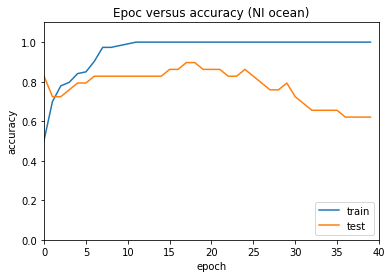

In [14]:
#Generating epoc s train versus test accuracy
noOfTrain = 3 # T = 3 (12 hours)
cnnData, yy = load_dataCNN(data_pad, noOfTrain)
lstmData, yy1 = load_dataLSTM(data_pad, noOfTrain)
model = build_model(cnnData.shape, lstmData.shape)
yy = yy.astype(int)
yy1 = yy1.astype(int)

kf = KFold(n_splits=5, shuffle=True,  random_state=0)
for train_index, test_index in kf.split(lstmData):
    break
   
Xc_train = cnnData[train_index]
yc_train = yy[train_index]
Xl_train = lstmData[train_index]
yl_train = yy1[train_index]
Xc_test = cnnData[test_index]
yc_test = yy[test_index]
Xl_test = lstmData[test_index]
yl_test = yy1[test_index]

history = model.fit([Xc_train, Xl_train], yl_train, batch_size=128, validation_data=([Xc_test, Xl_test], yl_test) ,epochs=40,verbose=1, shuffle = True)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis([0,40,0,1.1]) 
plt.title('Epoc versus accuracy (NI ocean)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

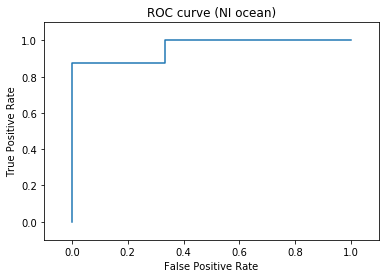

In [15]:
#Generating ROC curve for T = 3
ypred = model.predict([Xc_test, Xl_test])
ypred = ypred.reshape(len(ypred))
fpr , tpr , thresholds = roc_curve(yl_test , ypred)
plt.plot(fpr,tpr) 
plt.axis([-0.1,1.1,-0.1,1.1]) 
plt.title("ROC curve (NI ocean)")
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()


In [16]:
#Predicting two randomly generating cyclones
noOfTrain  = 5 # T= 5 (24 hour)
cnnData, yy = load_dataCNN(data_pad, noOfTrain)
lstmData, yy1 = load_dataLSTM(data_pad, noOfTrain)
yy = yy.astype(int)
yy1 = yy1.astype(int)

lXC, lyC = load_dataCNN(data_padl, noOfTrain)
nlXC, nlyC = load_dataCNN(data_padnl, noOfTrain)

lXL, lyL = load_dataLSTM(data_padl, noOfTrain)
nlXL, nlyL = load_dataLSTM(data_padnl, noOfTrain)

lyL = lyL.astype(int)
nlyL = nlyL.astype(int)
model = build_model(cnnData.shape, lstmData.shape)
model.fit([cnnData, lstmData], yy, batch_size=128 ,epochs=40,verbose=0, shuffle = True)
predictions = model.evaluate([lXC, lXL], lyL)
ypred = model.predict([lXC, lXL])
print("Cyclone name ", lCyclone)
print("POD  for the random unknonw cyclone with Landfall = ", predictions[1])
ypred = ypred.reshape(len(ypred))
ypred = np.where(ypred >= 0.5, 1,0)
print('actual  ', lyL)
print('predict ',ypred )

print("Cyclone name ", nlCyclone)
predictions1 = model.evaluate([nlXC, nlXL], nlyL)
print("POD  for the random unknonw cyclone without Landfall = ", predictions1[1])
ypred1 = model.predict([nlXC, nlXL])
ypred1 = ypred1.reshape(len(ypred))
ypred1 = np.where(ypred1 >= 0.5, 1,0)
print('actual  ', nlyL)
print('predict ',ypred1)

9/9 [==============================] - 3s 349ms/sample - loss: 0.3363 - acc: 1.0000
Cyclone name  2020245N23146
POD  for the random unknonw cyclone with Landfall =  1.0
actual   [1 1 1 1 1 1 1 1 1]
predict  [1 1 1 1 1 1 1 1 1]
Cyclone name  2020355N10115
9/9 [==============================] - 0s 3ms/sample - loss: 1.2217 - acc: 0.0000e+00
POD  for the random unknonw cyclone without Landfall =  0.0
actual   [0 0 0 0 0 0 0 0 0]
predict  [1 1 1 1 1 1 1 1 1]
